<h2 align="center">Predict Employee Churn with Decision Trees and Random Forests</h2>

### Task 1: Import Libraries
---

In [1]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

### Task 2: Exploratory Data Analysis
---

In [3]:
df = pd.read_csv("data/employee_data.csv")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
df.profile_report(title="Data Report")

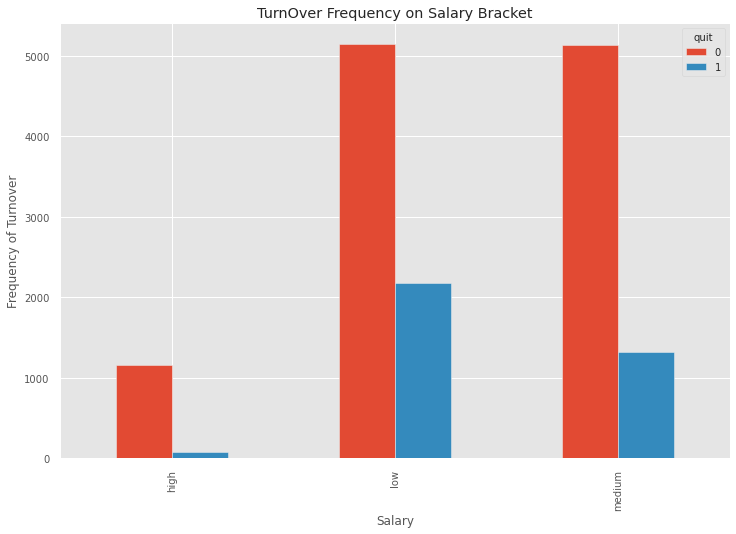

In [5]:
pd.crosstab(df.salary, df.quit).plot(kind="bar")
plt.title("TurnOver Frequency on Salary Bracket")
plt.xlabel("Salary")
plt.ylabel("Frequency of Turnover")
plt.show()

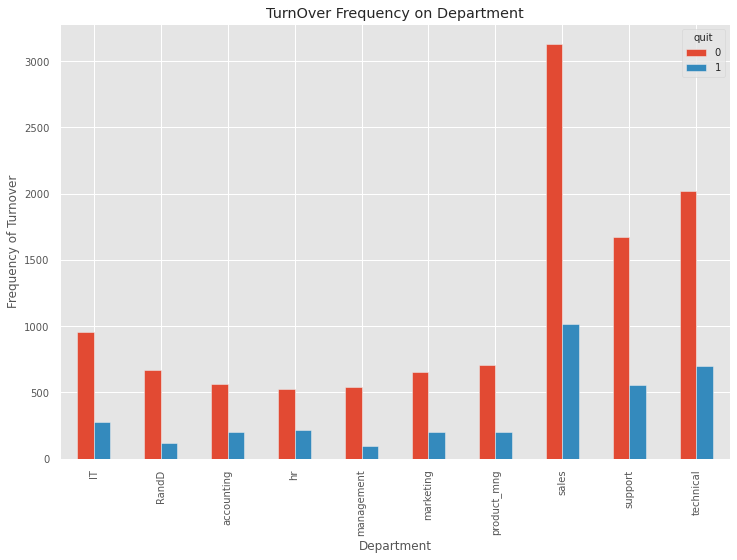

In [6]:
pd.crosstab(df.department, df.quit).plot(kind="bar")
plt.title("TurnOver Frequency on Department")
plt.xlabel("Department")
plt.ylabel("Frequency of Turnover")
plt.show()

### Task 3: Encode Categorical Features
---

In [8]:
cat_vars = ['department', 'salary']
for var in cat_vars:
    cat_list = pd.get_dummies(df[var], prefix=var)
    df = df.join(cat_list)

In [9]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0


In [10]:
df.drop(cat_vars, axis=1, inplace=True)

In [11]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department_IT,department_RandD,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


### Task 4: Visualize Class Imbalance
---

In [13]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

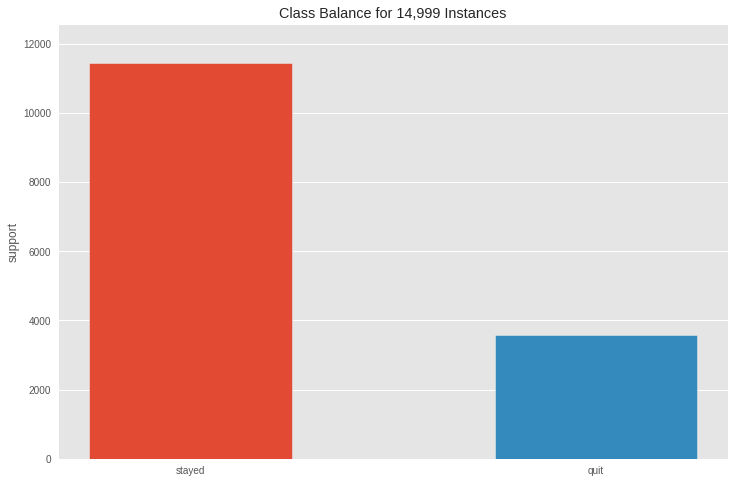

In [15]:
visualizer = ClassBalance(labels=['stayed', 'quit']).fit(df.quit)
visualizer.show()

### Task 5: Create Training and Test Sets
---

In [17]:
X = df.loc[:, df.columns != 'quit']
y = df['quit']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y )

### Task 6 & 7: Build an Interactive Decision Tree Classifier
---

Supervised learning: 
- The inputs are random variables $X = X_1, ..., X_p$;
- The output is a random variable $Y.$

- Data is a finite set $$\mathbb{L}=\{(x_i,y_i)|i=0, ..., N-1\}$$
where $x_i \in X = X_1 \times ... \times X_p$ and $y_i \in y$ are randomly drawn from $P_{X,Y}.$

E.g., $(x_i,y_i)=((\text{salary = low, department = sales, ...}),\text{quit = 1})$

- The goal is to find a model $\varphi_\mathbb{L}: X \mapsto y$ minimizing $$\text{Err}(\varphi_\mathbb{L}) = \mathbb{E}_{X,Y}\{L(Y, \varphi_\mathbb{L}(X))\}.$$

About:
 
 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:

![partition](assets/images/partition-feature-space.png)

- Decision trees generally have low bias but have high variance.
- We will solve the high variance problem in Task 8.

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

### Task 8: Build an Interactive Random Forest Classifier
---

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [ ]:
@interact
def plot_tree_rf(crit=,
                 bootstrap=,
                 depth=IntSlider(min=,max=,value=, continuous_update=False),
                 forests=IntSlider(min=,max=,value=,continuous_update=False),
                 min_split=IntSlider(min=,max=,value=, continuous_update=False),
                 min_leaf=IntSlider(min=,max=,value=, continuous_update=False)):
    
    
    

### Task 9: Feature Importance and Evaluation Metrics
---

In [ ]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

In [ ]:
### Type code below this line ###





In [ ]:
## Plotting Code ##
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

In [ ]:
## Plotting Code ##
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

visualizer = ROCAUC(dt, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

### Optional: Comparison with Logistic Regression Classifier
---

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV(random_state=1, n_jobs=-1,max_iter=500,
                             cv=10)

lr = logit.fit(X_train, y_train)

print('Logistic Regression Accuracy: {:.3f}'.format(accuracy_score(y_test, lr.predict(X_test))))

visualizer = ROCAUC(lr, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

In [2]:
! pip install pandas_profiling

     |████████████████████████████████| 266kB 623kB/s eta 0:00:01
     |████████████████████████████████| 3.1MB 4.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 5.2MB/s eta 0:00:01
     |████████████████████████████████| 12.4MB 2.0MB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 2.2MB/s eta 0:00:01
     |████████████████████████████████| 604kB 1.4MB/s eta 0:00:01
     |████████████████████████████████| 133kB 1.8MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/dd/82/c1fe128f3526b128cfd185580ba40d01371c5d299fcf7f77968e22dfcc2e/scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl
     |████████████████████████████████| 122kB 1.9MB/s eta 0:00:01
     |████████████████████████████████| 61kB 2.8MB/s eta 0:00:011
     |████████████████████████████████| 71kB 2.5MB/s eta 0:00:01
     |████████████████████████████████| 6.5MB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 1.6MB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 2

  Stored in directory: /home/sam/.cache/pip/wheels/f6/8b/23/41a1b516f6d8d4cc81f5bdb55394a47cdbe9659c53668d3c9e
  Stored in directory: /home/sam/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Stored in directory: /home/sam/.cache/pip/wheels/07/1c/dc/6831446f09feb8cc199ec73a0f2f0703253f6ae013a22f4be9
Successfully built confuse htmlmin imagehash
ERROR: phik 0.10.0 has requirement joblib>=0.14.1, but you'll have joblib 0.13.2 which is incompatible.
  Found existing installation: requests 2.22.0
    Uninstalling requests-2.22.0:
      Successfully uninstalled requests-2.22.0
  Found existing installation: matplotlib 3.1.0
    Uninstalling matplotlib-3.1.0:
      Successfully uninstalled matplotlib-3.1.0
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2
  Found existing installation: scipy 1.3.0
    Uninstalling scipy-1.3.0:
      Successfully uninstalled scipy-1.3.0
  Found existing inst

    Uninstalling tqdm-4.32.1:
      Successfully uninstalled tqdm-4.32.1
  Found existing installation: astropy 3.2.1
    Uninstalling astropy-3.2.1:
      Successfully uninstalled astropy-3.2.1


In [8]:
!conda install pandas

Solving environment: done

## Package Plan ##

  environment location: /home/sam/anaconda3

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |           py37_0         2.8 MB
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following packages will be UPDATED:

  conda                                       4.7.10-py37_0 --> 4.8.3-py37_0


Proceed ([y]/n)? ^C

CondaSystemExit: 
Operation aborted.  Exiting.



In [9]:
y

NameError: name 'y' is not defined